In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
from sklearn.preprocessing import MinMaxScaler

# Load the datasets
files = {
    "Amazon": r"AMAZON_daily.csv",
    "Apple": r"APPLE_daily.csv",
    "Google": r"GOOGLE_daily.csv",
    "Meta": r"META_daily.csv",
    "Netflix": r"NETFLIX_daily.csv"
}


data = {}
for company, file in files.items():
    data[company] = pd.read_csv(file)
    data[company] = data[company][['Date','Close']]





# 添加滞后特征
X=np.empty((0, 14))
y=np.empty((0,1))
Close_prices = {}
companies = ['Amazon', 'Apple','Google','Meta','Netflix']
for j, company in enumerate(companies):
    df = data[company].copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').reset_index(drop=True)
    df['Price Change']= df['Close']-df['Close'].shift(1)
    for i in range(1, 8):  # 添加前7天的收盘价作为特征
        df[[f'lag_{i}']] = df[['Price Change']].shift(i)
    # 移除2013年前的数据
    df = df[df['Date'].dt.year >= 2013]

    # 移除包含NaN的行
    df = df.dropna()

    data[company]=df

    Close_prices[company] = data[company]['Close']
    data[company] = data[company].drop('Close', axis=1)
    print(data[company])

    data[company]=np.hstack((data[company], np.zeros((len(data[company]), j))))
    data[company]=np.hstack((data[company], np.ones((len(data[company]), 1))))
    data[company]=np.hstack((data[company], np.zeros((len(data[company]), 4-j))))

    # 划分特征和目标变量
    X = np.vstack((X,data[company]))
    y= np.vstack((y,data[company][:,1].reshape(-1,1)))

y= np.array(y)
scalery = MinMaxScaler()
y = scalery.fit_transform(y)
X=np.array(X)
X=np.delete(X,1,axis=1)
scalerx = MinMaxScaler()
X[:,1:] = scalerx.fit_transform(X[:,1:])

           Date  Price Change     lag_1     lag_2     lag_3     lag_4  \
3933 2013-01-02      0.322001  0.284500 -0.156500 -0.016001 -0.499499   
3934 2013-01-03      0.058499  0.322001  0.284500 -0.156500 -0.016001   
3935 2013-01-04      0.033501  0.058499  0.322001  0.284500 -0.156500   
3936 2013-01-07      0.465500  0.033501  0.058499  0.322001  0.284500   
3937 2013-01-08     -0.104000  0.465500  0.033501  0.058499  0.322001   
...         ...           ...       ...       ...       ...       ...   
7033 2025-04-30     -2.970001 -0.309998 -1.290009  2.450012  5.939987   
7034 2025-05-01      5.779999 -2.970001 -0.309998 -1.290009  2.450012   
7035 2025-05-02     -0.220001  5.779999 -2.970001 -0.309998 -1.290009   
7036 2025-05-05     -3.629990 -0.220001  5.779999 -2.970001 -0.309998   
7037 2025-05-06     -1.340012 -3.629990 -0.220001  5.779999 -2.970001   

         lag_5     lag_6     lag_7  
3933  0.085000 -0.229000  0.175500  
3934 -0.499499  0.085000 -0.229000  
3935 -0.0160

In [39]:
# 训练模型并预测
def train_and_predict(X, y, test_size=0.2):

    cutoff_date = np.quantile(X[:,0], 1-test_size)
    test_ind = X[:,0]>= cutoff_date
    train_ind = X[:,0] < cutoff_date

    X=np.delete(X,0,axis=1)

    X_train = X[train_ind]
    X_test = X[test_ind]
    y_train = y[train_ind]
    y_test = y[test_ind]

    # 划分训练集和测试集
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

    # 训练线性回归模型
    model = LinearRegression()
    model.fit(X_train, y_train)
    print(model.coef_)

    # 预测
    y_pred = model.predict(X_test)

    # 计算评估指标
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    company = X_test[:,-5:]



    return {
        'model': model,
        'predictions': y_pred,
        'actual_prices': y_test,
        'company': company,
        'metrics': {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R²': r2
        }
    }

# 预测未来两个月的价格
def predict_future(model, last_data, start_date, end_date):
    # 生成未来日期
    future_dates = pd.date_range(start=start_date, end=end_date, freq='B')

    # 初始化预测结果列表
    future_predictions = []

    # 获取最后可用数据
    #last_row = last_data.iloc[-1].copy()
    features = last_data

    for date in future_dates:

        # 预测
        prediction = model.predict(features)[0]

        temp = np.concatenate((prediction,features[0][0:6]))
        features = np.concatenate((temp,features[0][7:])).reshape(1,-1)
        # 保存预测结果
        future_predictions.append({
            'date': date,
            'prediction': prediction
        })

    return pd.DataFrame(future_predictions)

# 可视化结果
def visualize_results(company, actual_results, train_results, metrics):
    plt.figure(figsize=(14, 7))


    # 绘制训练数据
    plt.plot(train_results,
             label='real price', color='blue')

    # 绘制测试数据预测结果
    plt.plot(actual_results,
             label='prediction price', color='red', linestyle='--')

    # 绘制未来预测
    plt.title(f'{company} Stock price prediction')
    plt.xlabel('Date')
    plt.ylabel('Close')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # 显示评估指标
    plt.figtext(0.15, 0.01,
                f"MSE: {metrics['MSE']:.2f} | RMSE: {metrics['RMSE']:.2f} | "
                f"MAE: {metrics['MAE']:.2f} | R²: {metrics['R²']:.2f}",
                ha="left", fontsize=9, bbox={"facecolor":"white", "alpha":0.5, "pad":5})

    plt.show()



[[-4.35101308e-02  2.12969660e-02 -3.61156899e-03  1.56524219e-02
  -4.54561699e-02 -3.91360182e-02 -3.90654133e-03 -9.17091690e-05
   4.56673595e-06 -1.08773387e-04 -9.20202308e-05  2.87936051e-04]]


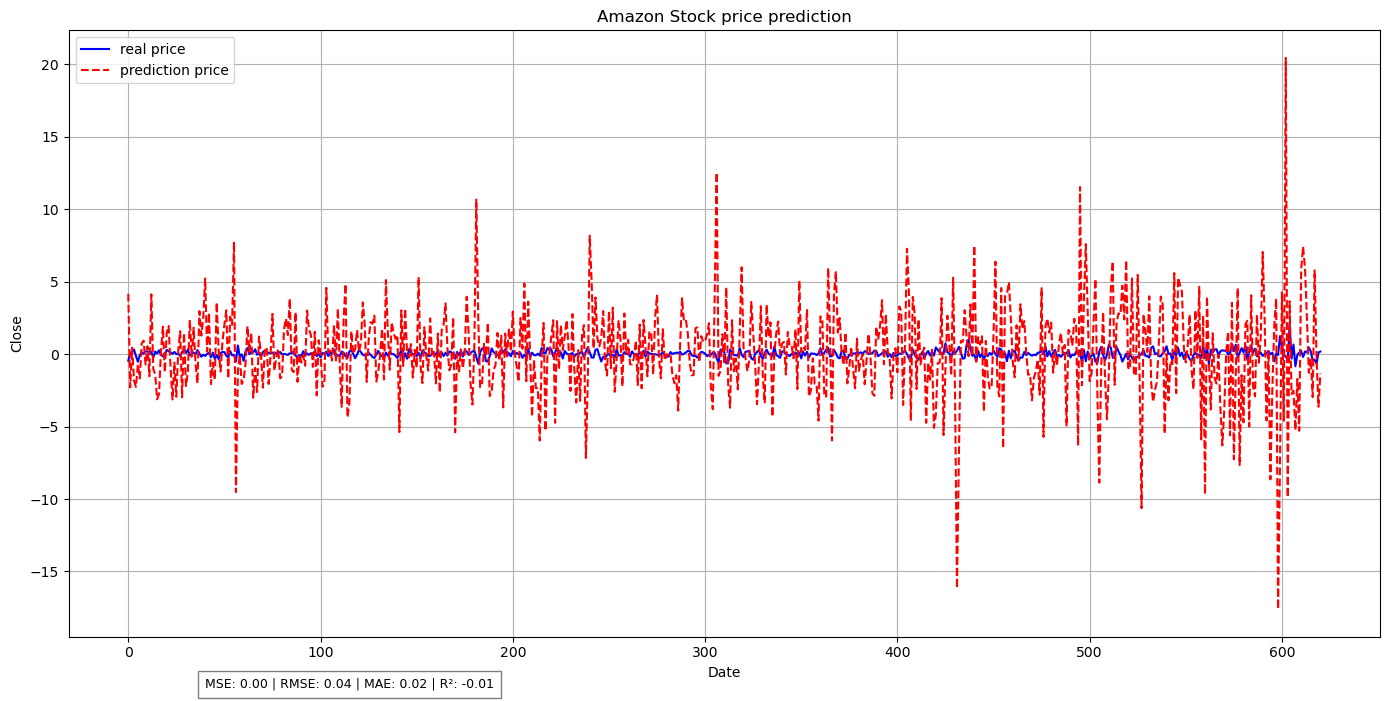

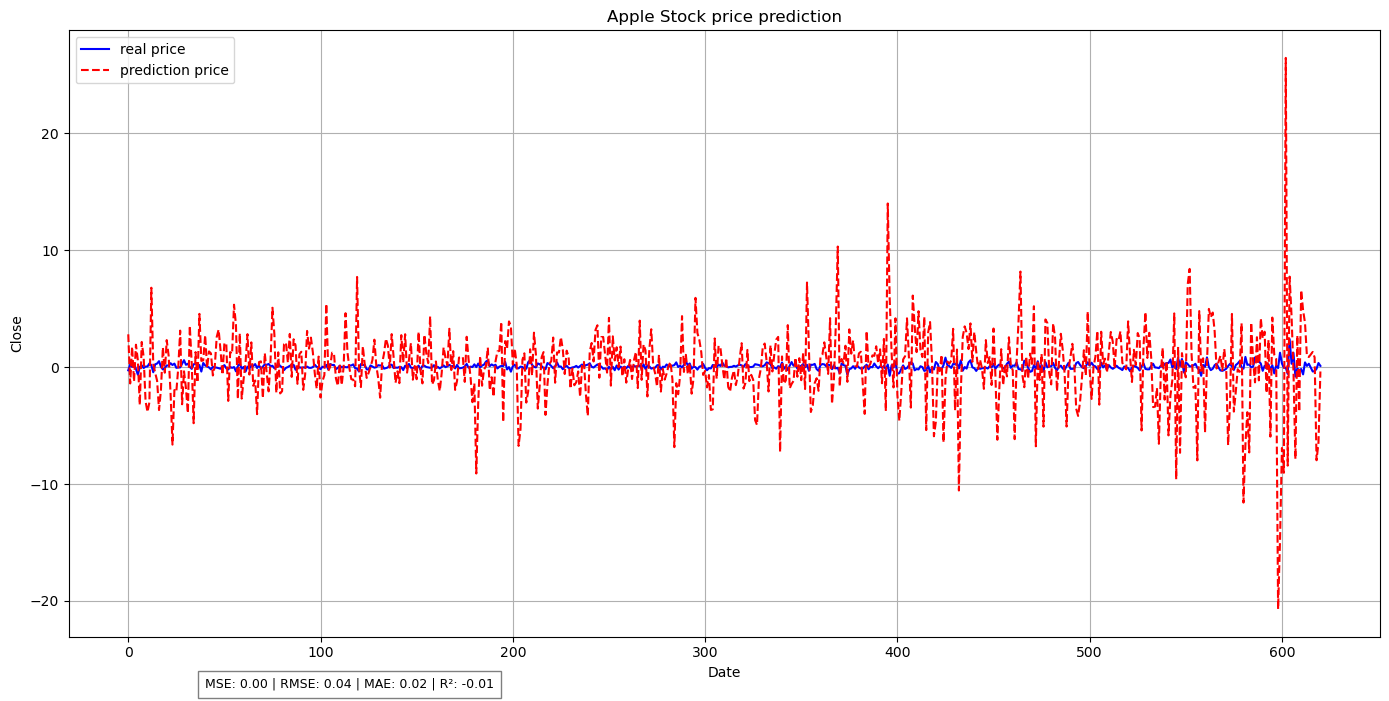

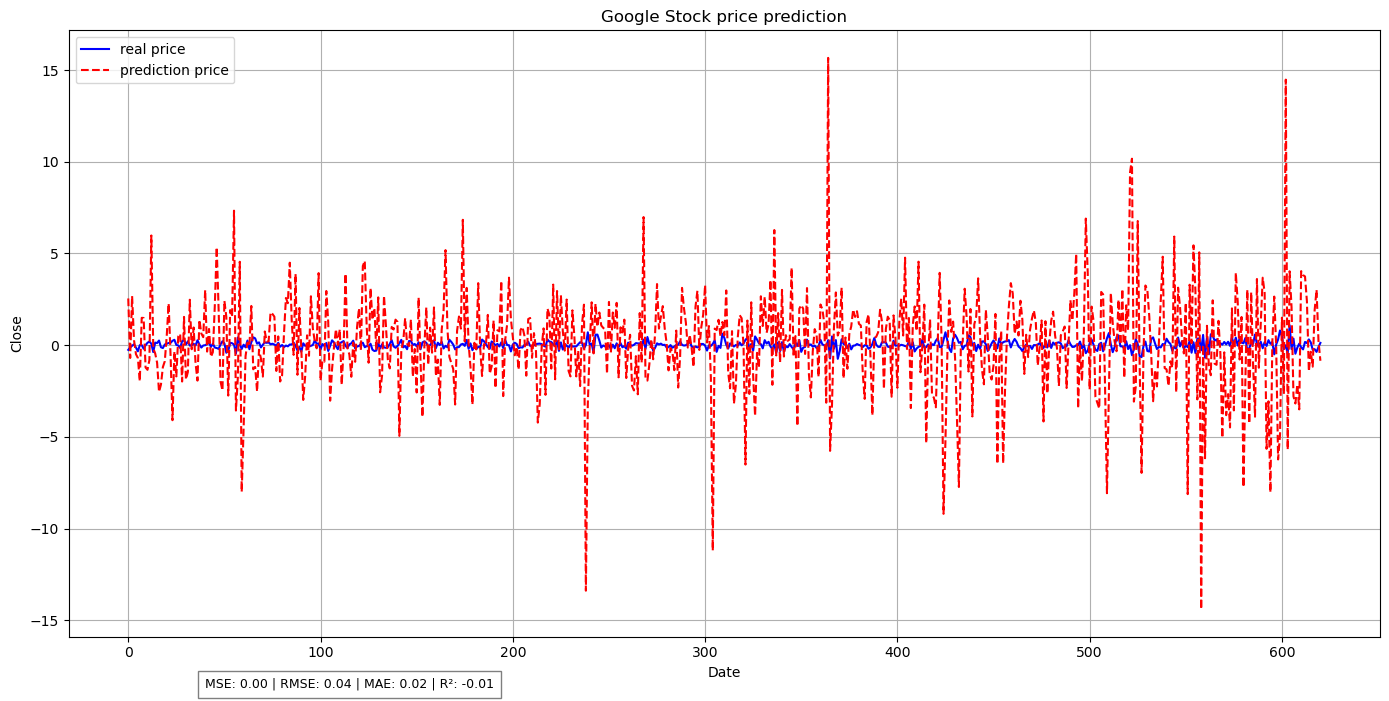

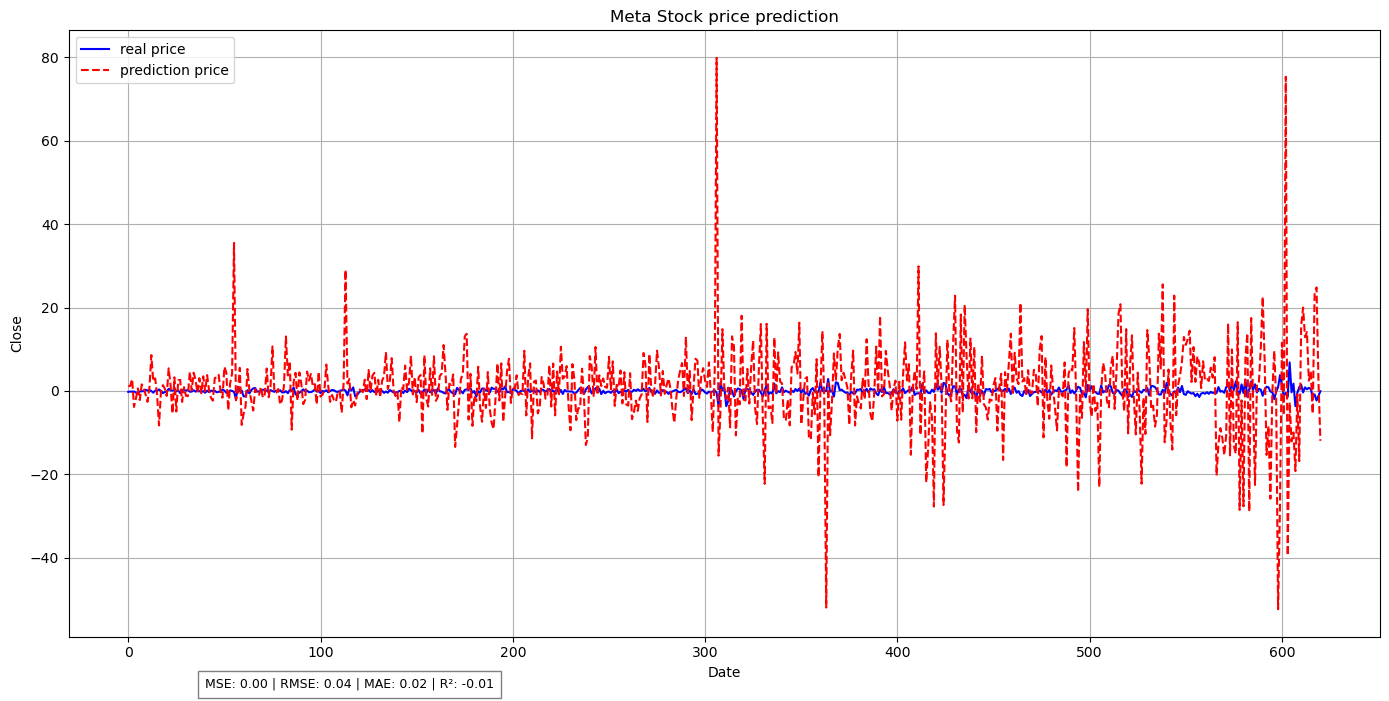

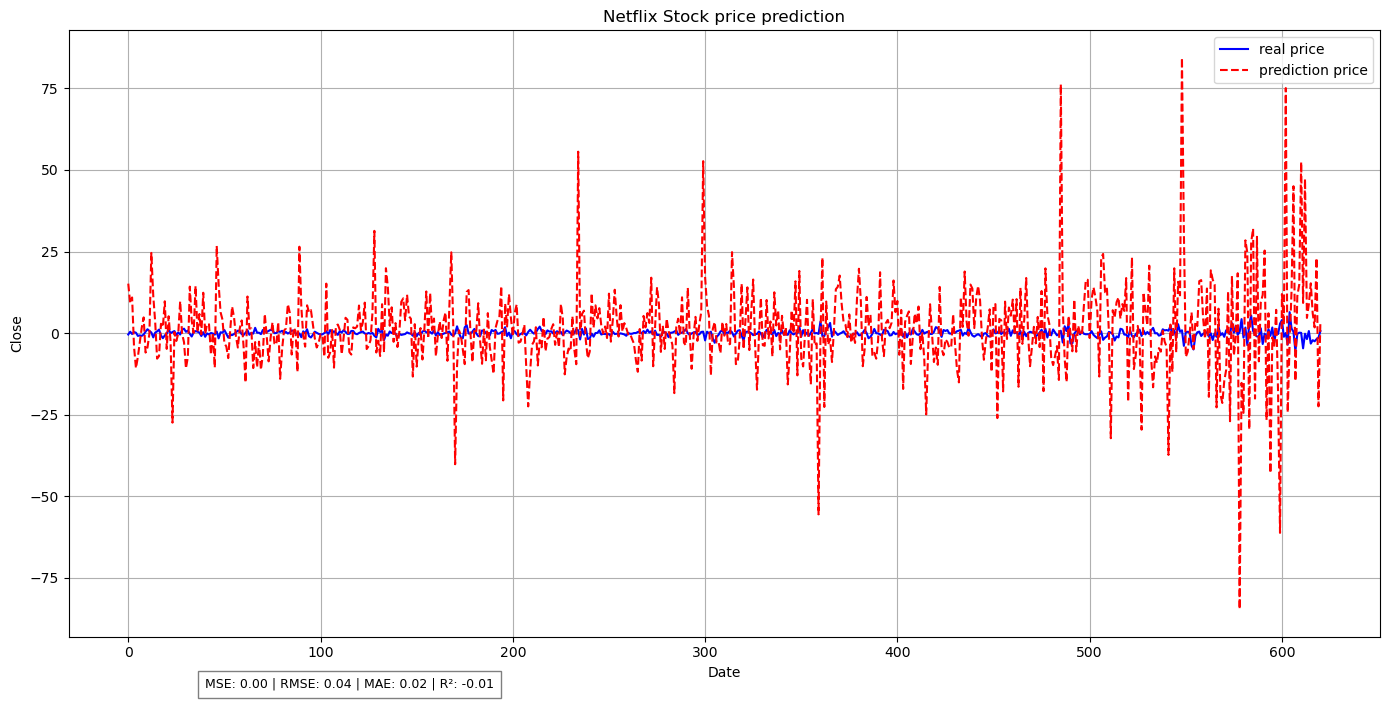

{'model': LinearRegression(),
 'predictions': array([[0.58923538],
        [0.59167223],
        [0.5922198 ],
        ...,
        [0.5825106 ],
        [0.58465932],
        [0.59438738]]),
 'actual_prices': array([[0.611527  ],
        [0.58031773],
        [0.59360344],
        ...,
        [0.70264258],
        [0.48306701],
        [0.60896591]]),
 'company': array([[1.0, 0.0, 0.0, 0.0, 0.0],
        [1.0, 0.0, 0.0, 0.0, 0.0],
        [1.0, 0.0, 0.0, 0.0, 0.0],
        ...,
        [0.0, 0.0, 0.0, 0.0, 1.0],
        [0.0, 0.0, 0.0, 0.0, 1.0],
        [0.0, 0.0, 0.0, 0.0, 1.0]], dtype=object),
 'metrics': {'MSE': 0.0014668281828073377,
  'RMSE': 0.038299192978538565,
  'MAE': 0.021235541135739496,
  'R²': -0.012506116953567847}}

In [61]:
dictionary =train_and_predict(X, y, test_size=0.2)
train_results = dictionary['predictions']
train_results = scalery.inverse_transform(train_results)
actual_results = dictionary['actual_prices']
actual_results = scalery.inverse_transform(actual_results)
companies = dictionary['company']
company_name = ['Amazon', 'Apple','Google','Meta','Netflix']
metrics = dictionary['metrics']

for i, company in enumerate(company_name):
  ind = companies[:,i]==1
  visualize_results(company, actual_results[ind], train_results[ind],metrics)

dictionary


[0.1777778833038679, 0.19527751557386186, -0.10345711211728294, -0.21652475807461913, 0.19720915622310017, 0.16195844337941126, 0.031540850611299645, 0.03121985776730251, 0.0518221162531405, 0.03762340372521725, 0.022491933082647537, 0.028460073223204704, 0.03350822387949137, 0.03283362990807836, 0.0325524760586423, 0.033788542596536165, 0.034186590158006944, 0.03378212478067286, 0.033609120605331055, 0.03364540430288077, 0.03360528401420808, 0.03353672623863962, 0.033533994485891186, 0.03355550437944907, 0.033560831361903284, 0.03356107401353118, 0.03356560123976624, 0.03356869085540618, 0.03356813232216265, 0.03356713658706231, 0.03356692418408051, 0.03356672649990771, 0.03356640686375954, 0.033566288530272104, 0.03356633931239338, 0.03356638344891924, 0.03356639922278637, 0.033566420536587704, 0.0335664392411591, 0.03356644308653358, 0.03356643995608273, 0.033566437797523545, 0.033566436345063476, 0.03356643468777813]
[0.09952511772181737, -0.14735657192733342, -0.12802097510574045,

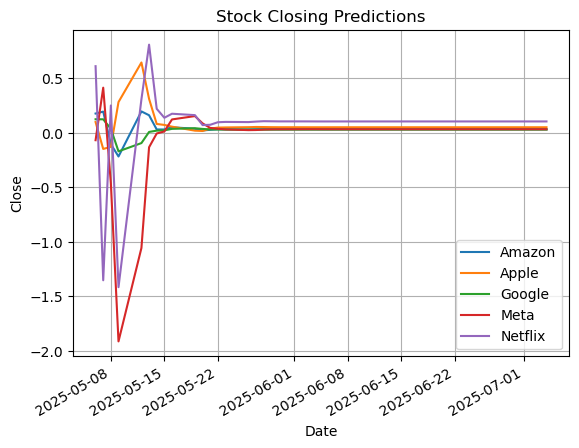

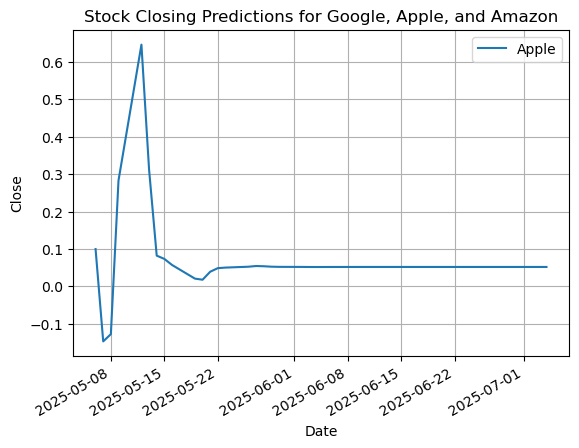

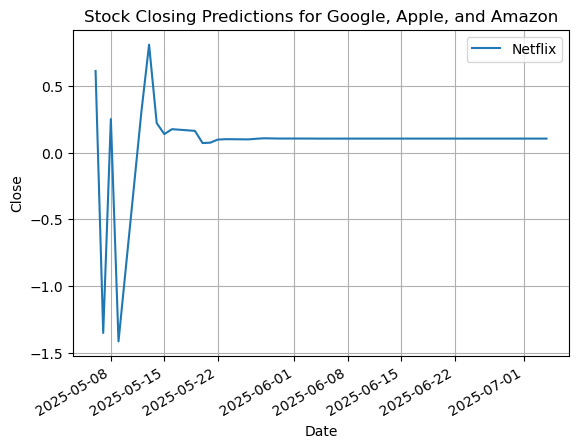

In [62]:
model = dictionary['model']
start_date = np.datetime64('2025-05-06 00:00:00')
end_date = np.datetime64('2025-07-06 00:00:00')
companies = ['Amazon', 'Apple','Google','Meta','Netflix']
dict={}
for company in companies:
    last_data = data[company][-1,2:].reshape(1,-1)
    last_data = scalerx.transform(last_data)
    var =predict_future(model, last_data, start_date, end_date)
    x0=Close_prices[company].iloc[-2]
    dict[company+'preds']=[]
    predictions = scalery.inverse_transform(var['prediction'].to_numpy().reshape(-1,1))
    for pred in predictions:
        x0 += pred[0]
        dict[company+'preds'].append(pred[0])
    dict[company+'date'] = var['date']
    print(dict[company+'preds'])
    plt.plot(var['date'], dict[company+'preds'], label = company)
plt.title('Stock Closing Predictions')
plt.legend()
plt.gcf().autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Close')
plt.grid(True)
plt.show()

for company in ['Apple', 'Netflix']:
  plt.plot(dict[company+'date'],dict[company+'preds'], label=company)
  plt.gcf().autofmt_xdate()
  plt.legend()
  plt.xlabel('Date')
  plt.ylabel('Close')
  plt.grid(True)
  plt.title('Stock Closing Predictions for Google, Apple, and Amazon')
  plt.show()